## Neocognitron group 4
### Members: Zernab Saeed, Alejandro Lopez, Daniel Sindel, Pratap Karki, Michael Kwarteng

Caption generation is a challenging artificial intelligence problem of generation human-readable
textual description given a photographic image. It requires both understanding the domain of
computer vision and a language model from the field of natural language processing. The objective
of this demo is help be able to use jupyter notebook to build a deep learning Neural Network that
generates a caption after analyzing an image. We will use the Encoder-Decoder Architecture to
build the network. To feed the model, we prepare data from the ImageNet data collection. The
Xception, which is a pre-trained Convolutional Neural Network that extracts picture features from
our dataset,serves as the encoder’s output layer. We concatenated this model with a Long-Short
Term Memory layer that acts as a decoder which will decode the vector representation into the
corresponding output sequence using another recurrent hidden layer.

In [186]:
import os
import re
import gc
import numpy as np 
import collections
from PIL import Image
from textwrap import wrap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from tqdm.notebook import tqdm

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add

In [202]:
def clean_description(desc, stopwords):
    clean = desc.lower()
    clean = re.sub('[^a-z]',' ',clean)
    tokens = clean.split(' ')
    clean = ' '.join([w for w in tokens if w not in stopwords and len(w)>1])
  
    return clean

In [203]:
def get_vocabulary(dictionary):
    vocab = set()

    for desc_list in dictionary.values():
        for desc in desc_list:
            words = desc.split(' ')
            for word in words:
                vocab.add(word)

    return vocab

In [204]:
def create_list(dictionary):
    final_list = []
    
    for desc_list in dictionary.values():
        for desc in desc_list:
            final_list.append(desc)

    return final_list

In [205]:
def fit_tokenizer(dictionary):
    desc_list = create_list(dictionary)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [206]:
def convert_to_input(tokens, pos, im_name, max_len, vocab_len, tokenizer, img_predictions):
    inp = tokens[:pos]
    out = tokens[pos]
    inp = pad_sequences(sequences=[inp], maxlen=max_len)[0]
    out = to_categorical(y=[out], num_classes=vocab_len, dtype='bool')[0]
  
    return img_predictions.get(im_name)[0], inp, out

In [207]:
def convert_all_to_input(dictionary, max_len, vocab_len, tokenizer, img_predictions):
  
    X_1 = list()
    X_2 = list()
    y = list()

    for im_name, descriptions in tqdm(dictionary.items()):
        if im_name in img_predictions.keys():
            for desc in descriptions:
                tokens = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(tokens)):
                    _X_1, _X_2, _y = convert_to_input(tokens, i,
                                    im_name, max_len, vocab_len, tokenizer, img_predictions)
                    X_1.append(_X_1)
                    X_2.append(_X_2)
                    y.append(_y)
    return np.array(X_1), np.array(X_2), np.array(y)

In [208]:
def shuffle_arrays(arrays, set_seed=-1):
   # """Shuffles arrays in-place, in the same order, along axis=0

  #  Parameters:
  #  -----------
   # arrays : List of NumPy arrays.
   # set_seed : Seed value if int >= 0, else seed is random.
    #"""
    assert all(len(arr) == len(arrays[0]) for arr in arrays)
    seed = np.random.randint(0, 2**(32 - 1) - 1) if set_seed < 0 else set_seed

    for arr in arrays:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

In [209]:
def create_model(cnn_len, max_len, vocab_len):
    cnn_in = Input(shape=(cnn_len,))
    cnn_x = Dropout(0.5)(cnn_in)
    cnn_out = Dense(units=256, activation='relu')(cnn_x)

    lstm_in = Input(shape=(max_len,))
    lstm_x = Embedding(vocab_len, 256, mask_zero=True)(lstm_in)
    lstm_x = Dropout(0.5)(lstm_x)
    lstm_out = LSTM(256)(lstm_x)

    combined = add([cnn_out, lstm_out])
    combined_x = Dense(units=256, activation='relu')(combined)
    output = Dense(units=vocab_len, activation='softmax')(combined_x)

    model = Model(inputs=[cnn_in, lstm_in], outputs=output)

    return model

In [210]:
def word_for_id(integer, tokenizer):

    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    
    return None

In [211]:
def generate_desc(model, tokenizer, photo, max_len):

    start_text = 'startseq'

    for i in range(max_len):

        tokens = tokenizer.texts_to_sequences([start_text])[0]

        tokens = pad_sequences([tokens], maxlen=max_len)

        pred = model.predict([photo, tokens], verbose=0)

        pred = np.argmax(pred)

        word = word_for_id(pred, tokenizer)

        if word is None:
            break

        start_text += ' ' + word

        if word == 'endseq':
            break

    return start_text

In [212]:
with open('/home/jovyan/s21-team4-project/xception_example/xception_example.txt', 'r') as f:
    few_desc = f.read().split('\n')

In [213]:
few_desc[:5]

['image_0.JPEG\tparakeet on laptop',
 'image_1.JPEG\tdog with sheep',
 'image_2.JPEG\tcow udder',
 'image_3.JPEG\ttwo puppies playing',
 'image_4.JPEG\tEgyptian cat looking at camera']

In [214]:
stop_words = ['on', 'with', 'looking', 'the', 'was']

In [215]:
all_dict = dict()

for desc in all_desc:
    if len(desc) < 1:
        continue
    file_name, file_desc = desc.split('\t')[0].split('.')[0], desc.split('\t')[1]
  
    if file_name not in all_dict.keys():
        all_dict[file_name] = []

    cleaned_desc = clean_description(file_desc, stopwords)
    cleaned_desc = 'startseq ' + cleaned_desc + ' endseq'

    all_dict[file_name].append(cleaned_desc)

In [216]:
vocab = get_vocabulary(all_dict)

In [217]:
print('Total images:', len(all_dict))
print('Total vocabulary without stopwords:', len(vocab))

Total images: 101
Total vocabulary without stopwords: 171


In [218]:
whole_list = [item.strip('startseq').strip('endseq').strip(' ') for sublist in list(all_dict.values()) for item in sublist]

In [219]:
whole_list_len = [len(sent) for sent in whole_list]

In [220]:
avg_len = int(np.mean([len(sentence.split()) for sentence in whole_list]))
avg_len

3

In [221]:
words = [w for a in all_sent_list for w in a.split(' ')]

In [222]:
counts = collections.Counter(words)
most_common = counts.most_common()
most_common[:15]

[('cat', 34),
 ('dog', 33),
 ('in', 18),
 ('and', 13),
 ('black', 12),
 ('white', 11),
 ('to', 9),
 ('camera', 8),
 ('trying', 8),
 ('two', 7),
 ('brown', 7),
 ('at', 6),
 ('sheep', 5),
 ('cow', 5),
 ('cute', 5)]

In [223]:
keys = [tupl[0] for tupl in most_common][:15]
values = [tupl[1] for tupl in most_common][:15]

In [224]:
lengths = set()
for cap_list in all_dict.values():
    lengths.add(len(cap_list))

print('Number of captions for each image: ', lengths)

Number of captions for each image:  {1}


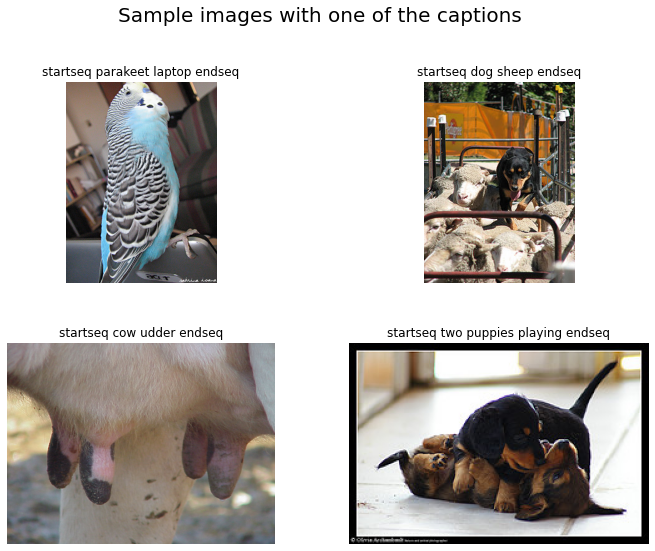

In [225]:
fig = plt.figure()
fig.suptitle('Sample images with one of the captions', fontsize=20)

zoom = 2
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.imshow(plt.imread('xception_example/images/' +list(all_dict.keys())[i-1]+'.JPEG'))
    title = ax.set_title('\n'.join(wrap(all_dict.get(list(all_dict.keys())[i-1])[0], 60)))
    fig.tight_layout(h_pad=2)
    title.set_y(1.05)
    plt.axis('off')
    fig.subplots_adjust(top=0.85, hspace=0.3)

plt.show()

In [226]:
model = Xception(include_top=False, pooling='avg')

In [227]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_11[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [228]:
predictions = dict()

for dirpath, dirname, files in os.walk('xception_example/images'):
    for filename in tqdm(files):
        img_path = os.path.join(dirpath, filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            img = img.resize((299,299))
            img = np.expand_dims(img, axis=0)
            img = img/127.5
            img = img - 1.0
             
            predictions[filename.split('.')[0]] = model.predict(img)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [229]:
print('Number of extracted features:', len(predictions.get(list(predictions.keys())[0])[0]))

Number of extracted features: 2048


In [230]:
tokenize_words = fit_tokenizer(all_dict)

In [231]:
vocab_length = len(tokenizer.index_word) + 1
vocab_length

171

In [232]:
max_length = len(max(create_list(all_dict)))
max_length

39

In [234]:
network_length = predictions[list(predictions.keys())[0]].shape[1]
network_length

2048

In [235]:
X_1, X_2, y = convert_all_to_input(all_dict, max_length, vocab_length, tokenize_words, predictions)

  0%|          | 0/101 [00:00<?, ?it/s]

In [236]:
shuffle_arrays([X_1, X_2, y])

In [237]:
model = create_model(network_length, max_length, vocab_length)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
            loss=tf.keras.losses.categorical_crossentropy, 
            metrics=[tf.keras.metrics.categorical_accuracy])

In [238]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 39)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 39, 256)      43776       input_13[0][0]                   
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 2048)         0           input_12[0][0]                   
____________________________________________________________________________________________

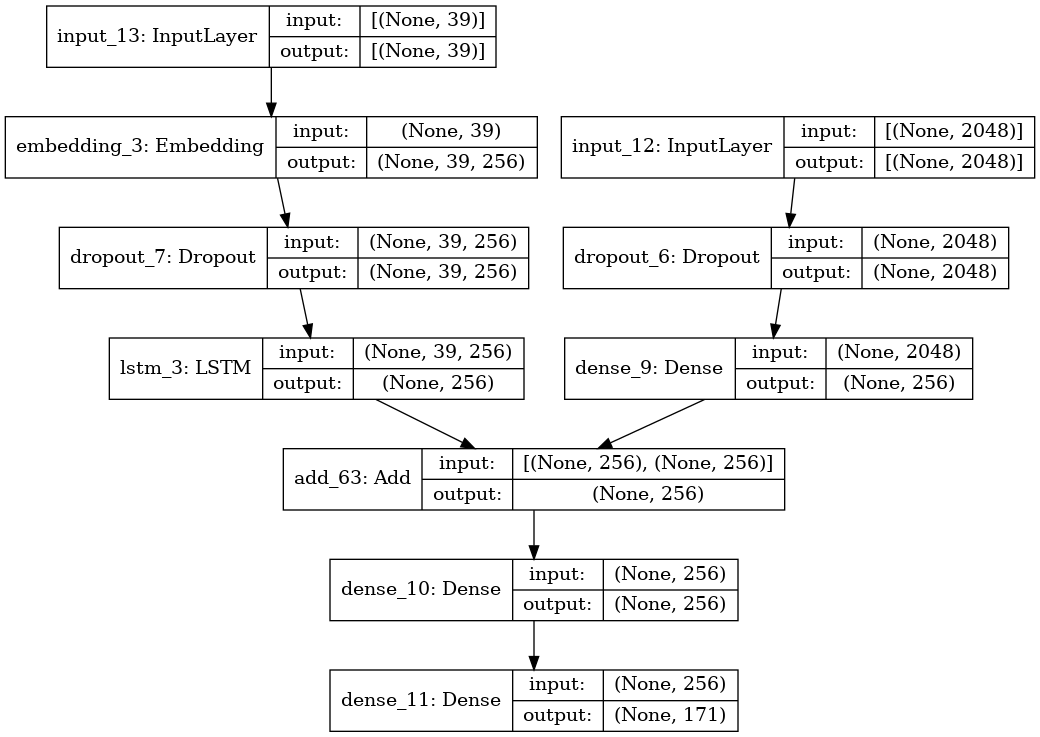

In [239]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit([X_1, X_2], y, epochs = 50, batch_size = 256)

Epoch 1/50
2/2 [==============================] - 11s 847ms/step - loss: 5.1028 - categorical_accuracy: 0.0545
Epoch 2/50
2/2 [==============================] - 2s 808ms/step - loss: 4.6392 - categorical_accuracy: 0.2157
Epoch 3/50
2/2 [==============================] - 2s 955ms/step - loss: 4.4035 - categorical_accuracy: 0.2014
Epoch 4/50
2/2 [==============================] - 2s 823ms/step - loss: 4.2267 - categorical_accuracy: 0.2066
Epoch 5/50
2/2 [==============================] - 2s 797ms/step - loss: 4.0731 - categorical_accuracy: 0.2052
Epoch 6/50
2/2 [==============================] - 2s 844ms/step - loss: 4.0356 - categorical_accuracy: 0.1973
Epoch 7/50
2/2 [==============================] - 2s 919ms/step - loss: 3.9047 - categorical_accuracy: 0.2376
Epoch 8/50
2/2 [==============================] - 2s 849ms/step - loss: 3.8302 - categorical_accuracy: 0.2133
Epoch 9/50
2/2 [==============================] - 2s 788ms/step - loss: 3.7950 - categorical_accuracy: 0.2003
Epoch 10/

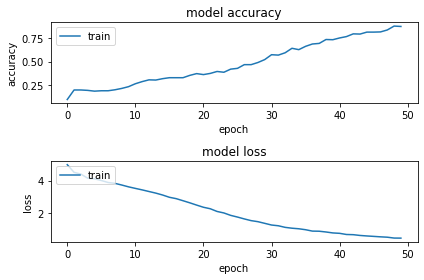

In [180]:
plt.figure(1) 
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
#plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show() 

In [181]:
img_path = 'xception_example/images/image_1.JPEG'
img = Image.open(img_path)
img2 = img.copy()
img = img.resize((299,299))
img = np.expand_dims(img, axis=0)
img = img/127.5
img = img - 1.0
print(img.shape)
predict = model.predict(img)

plt.figure(figsize=(10, 10))
plt.imshow(img2)
plt.axis('off')
plt.show()

caption = generate_desc(model, tokenize_words, predict, vocab_length)
caption = caption.strip('startseq').strip('endseq')
print(caption)

(1, 299, 299, 3)


ValueError: in user code:

    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:204 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_2 expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 299, 299, 3) dtype=float32>]
